## Import modules

In [1]:
import numpy as np

# to read data
import pickle

# to plot the data
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# import python file containing functions
!pip install import_ipynb
import import_ipynb
import myfunctions

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=7e761fd264c5934c3803fb471910ee48bdcebc683baf597306e094c34dee26f5
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
importing Jupyter notebook from myfunctions.ipynb


In [3]:
# to relead notebook after editing
import importlib
importlib.reload(myfunctions)

importing Jupyter notebook from myfunctions.ipynb


<module 'myfunctions' from 'myfunctions.ipynb'>

## get and read data

In [4]:
myfunctions.download_file(url = 'https://drive.google.com/u/0/uc?id=1CdYxeX8g9wxzSnz6R51ELmJJuuZ3xlqa&export=download',
                          saveAs = 'anamoly_dataset.pickle')

infile = open('anamoly_dataset.pickle','rb')
data = pickle.load(infile)
infile.close()

features = 3
train_data = [ [ [input[:,i] for i in range(features) ], label ] for input,label in zip(data[0],data[1]) ]
test_data = [ [ [ input[:,i] for i in range(features) ], label ] for input,label in zip(data[2],data[3]) ]

file downloaded


In [5]:
classes = ["normal","anamoly"]
sample_len = 50
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')
print('length of each channel is', sample_len)

number of classes : 2

train data contains 50000 samples
test data contains 10000 samples

each sample has 3 channels : x,y and force
length of each channel is 50


## patches

In [6]:
train_inputs, train_labels = myfunctions.dataToPatches(train_data, window_size=10, stride=5, resizeTo=100, smooth=False, normalize=True)
test_inputs,  test_labels  = myfunctions.dataToPatches(test_data,  window_size=10, stride=5, resizeTo=100, smooth=False, normalize=True)

In [7]:
train_inputs = np.array(train_inputs)
test_inputs = np.array(test_inputs)

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

In [8]:
train_loader, val_loader, test_loader = myfunctions.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=50)

## neural network

### define network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [10]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 8, train loss: 0.451, val loss: 0.452
epoch: 16, train loss: 0.449, val loss: 0.449
epoch: 24, train loss: 0.442, val loss: 0.444
epoch: 32, train loss: 0.436, val loss: 0.444
epoch: 40, train loss: 0.431, val loss: 0.433
epoch: 48, train loss: 0.427, val loss: 0.430

Finished Training


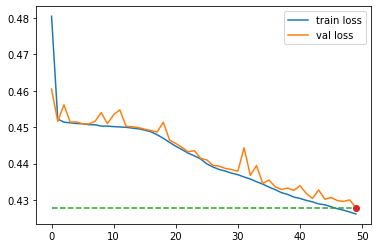

In [11]:
best_params = myfunctions.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=50)

In [12]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [13]:
print("evaluation results on train data")
myfunctions.evaluate(net,train_loader,classes)
print("evaluation results on test data")
myfunctions.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

      normal     0.8443    0.9980    0.9147    281165
     anamoly     0.8901    0.0817    0.1496     56335

    accuracy                         0.8450    337500
   macro avg     0.8672    0.5398    0.5322    337500
weighted avg     0.8520    0.8450    0.7870    337500

evaluation results on test data



              precision    recall  f1-score   support

      normal     0.8413    0.9978    0.9129     74736
     anamoly     0.8771    0.0786    0.1442     15264

    accuracy                         0.8419     90000
   macro avg     0.8592    0.5382    0.5285     90000
weighted avg     0.8474    0.8419    0.7825     90000

